# My Own Decision Tree Classifier

In [427]:
# import data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [459]:
import numpy as np
def label_it(D):
  """ return the most likely class """
  X,y = D
  v,c = np.unique(y,return_counts=True)
  ind = np.argmax(c)
  return v[ind]

def to_freq(y,debug=False):
  """convert to frequencies for each class"""
  p =np.array([len(y[y==cl])/len(y) for cl in np.unique(y)])
  if debug:
    print('from function to_freq',p)
  return p

def split_data(D,split):
  """split the data set"""
  X,y = D
  idx, threshold = split
  idx=int(idx)
  Xl=X[X[:,idx] <= threshold,:]
  yl=y[X[:,idx] <= threshold]
  Xr=X[X[:,idx] > threshold,:]
  yr=y[X[:,idx] > threshold]

  Dl = (Xl,yl)
  Dr = (Xr,yr)
  return (Dl,Dr)


def get_thresholds_from_vec(x):
  """ thresholds are the middle points of consecutive unique points """
  return 0.5*np.diff(np.unique(x)) + np.unique(x)[:-1]

def get_threshold_from_mat(X):
  """ call get_thresholds from vec, and zip all the results """
  ns,nf = X.shape
  tmp=[get_thresholds_from_vec(X[:,i]) for i in range(nf)]
  ids = np.concatenate([(i*np.ones(len(item))) for i, item in zip(np.arange(nf),tmp)])
  return [(idx,t) for idx, t in zip(ids,np.concatenate(tmp))]

def get_imp(p,metric='entropy'):
  """ Calculate the impurity index
  p: is the probability vector, the sum of which equal to 1 """
  return {
       'entropy': (-p*np.log2(p)).sum(),
       'error' : 1-np.max(p),
       'gini': (p*(1-p)).sum()
      }.get(metric)

def info_gain(D,split,metric='entropy'):
  """ the information gain of a given split
  split: (idx_feature, threshold) is a tuple """
  Dl,Dr = split_data(D,split)
  Nl = len(Dl[1])
  Nr = len(Dr[1])
  Np = len(D[1])
  Il = get_imp(to_freq(Dl[1]),metric=metric)
  Ir = get_imp(to_freq(Dr[1]),metric=metric)
  Ip = get_imp(to_freq(D[1]),metric=metric)
  return Ip - Nl/Np * Il - Nr/Np*Ir


###################################################
# class definition 
class BT_node(object):
  """ a simple binary tree node base class"""
  def __init__(self,Data=None,parent=None,metric='entropy',separable=True,updated=False):
    self.Data = Data
    self.label = label_it(self.Data)
    self.parent = parent
    self.level = self.parent.level+1 if self.parent is not None  else 0
    self.metric = metric
    self.separable = separable
    self.updated = updated

  def update(self):
    X,y = self.Data
    if len(y) <= 1 or len(np.unique(y))==1:
      self.lchild = None
      self.rchild = None
      self.split = None
      self.separable = False
    else:
      split,Dl,Dr = self.get_child()
      self.lchild = BT_node(Data=Dl,parent=self)
      self.rchild = BT_node(Data=Dr,parent=self)
      self.split = split
    
    self.updated = True
  def get_child(self):
    """ train the decision tree """
    X,y = self.Data
    sps = get_threshold_from_mat(X)
    IGs = np.array([info_gain((X,y),sp,self.metric) for sp in sps])
    # return the first maximum information gain
    cond = IGs==np.max(IGs)
    self.IG_max = IGs[cond]
    tmp = np.array(sps)[cond]
    split = (int(tmp[0,0]),tmp[0,1])
    # calculate the class label 
    Dl,Dr = split_data((X,y),split)
    return (split,Dl,Dr)

  def info(self):
    """ print out informations """
    print('split is: ',self.split)
    print('childrens are: ',self.lchild,self.rchild)
    print('node depth is: ',self.level)
    print('parent is: ',self.parent)

  def find_leaf(self,x,depth):
    node = self
    if not node.updated:
      node.update()
    while depth > node.level and node.separable:
      #print('node level: %d' %(node.level))
      if node.split is None:
            break
      if x[node.split[0]] <= node.split[1]:
       # print('the %d feature is less than threshold %.2f' %node.split)
        if node.lchild is not None:
          node = node.lchild
        else:
          break
      else:
        if node.rchild is not None:
          node = node.rchild
        else:
          break
      if not node.updated:
        node.update()
    
    return node.label

class Decision_Tree(object):
  """ Decision Tree, by Wensheng Sun"""
  def __init__(self,max_depth=3,random_state=1,impurity_fun='entropy',debug=False):
    self.random_state=random_state
    self.impurity_fun = impurity_fun
    self.max_depth = max_depth
    self.debug = debug

  def fit(self,X,y):
    """ growing the Binary Tree """
    self.root = BT_node((X,y),metric=self.impurity_fun)
    self.root.update()
    self.root.info()

  def predict(self,X):
    """ predict the results"""
    return np.array([self.root.find_leaf(x,self.max_depth) for x in X])



In [460]:
  # instantiate the Decision Tree classifier
  dc = Decision_Tree(impurity_fun='entropy',max_depth=4)
  dc.fit(X_train,y_train)
  

split is:  (0, 2.5999999999999996)
childrens are:  <__main__.BT_node object at 0x7f5678c6aba8> <__main__.BT_node object at 0x7f5678c6a828>
node depth is:  0
parent is:  None


In [461]:
dc.predict(X_test)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 0,
       0])

In [462]:
y_test

array([2, 0, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0,
       0])

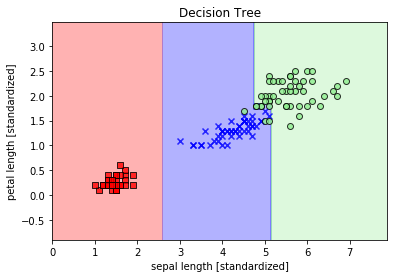

In [463]:
  import pandas as pd
  import matplotlib.pyplot as plt
  import numpy as np
  from Perceptron import plot_decision_regions

  #plt.figure()
  plot_decision_regions(X,y,classifier=dc)
  plt.title('Decision Tree')
  plt.xlabel('sepal length [standardized]')
  plt.ylabel('petal length [standardized]')
  plt.show()
